In [1]:
import numpy as np
import pandas as pd
import os
import glob
import joblib

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerBase
import seaborn as sns

from nilearn import plotting 
from nilearn.image import smooth_img, swap_img_hemispheres, resample_img
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn.input_data import NiftiMasker
import nibabel as nib

import scipy.stats
from scipy.stats import pearsonr, spearmanr, ttest_ind
import statsmodels.api as sm

import llms_brain_lateralization as lbl
from llms_brain_lateralization import make_dir

np.random.seed(1234)

rc={'font.size': 12, 'axes.labelsize': 14, 
    'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(rc=rc)
sns.set_style('darkgrid')

In [2]:
subject_list = ['EN057', 'EN058', 'EN059', 'EN061', 'EN062']

In [3]:
save_fig = True

In [4]:
if save_fig:
    fig_folder = lbl.figures_folder
    make_dir(fig_folder)

In [5]:
n_subjects = len(subject_list)

In [6]:
glm_folder = os.path.join(lbl.home_folder, 'llms_brain_correlations_individual')
df_model_info = pd.read_csv('model_info_en.csv', index_col=0)

df_model_info = df_model_info[df_model_info['model_name'].str.startswith('Qwen')|df_model_info['model_name'].str.startswith('gpt')]
df_model_info = df_model_info.reset_index()

In [7]:
df_model_info

,index,model_name,n_parameters,n_layers,n_hid,ppl,hellaswag
0,0,gpt2,124439808,12,768,25.187994,31.53
1,1,gpt2-medium,354823168,24,1024,18.473879,39.38
2,2,gpt2-large,774030080,36,1280,16.454109,45.62
3,3,gpt2-xl,1557611200,48,1600,14.795066,50.89
4,12,Qwen1.5-0.5B,463987712,24,1024,13.229901,49.05
5,13,Qwen1.5-1.8B,1836828672,24,2048,10.293191,61.42
6,14,Qwen1.5-4B,3950369280,40,2560,8.048015,71.58
7,15,Qwen1.5-7B,7721324544,32,4096,7.094688,78.51
8,16,Qwen1.5-14B,14167290880,40,5120,6.649388,81.08


In [8]:
model_names = df_model_info['model_name'].to_numpy()
n_parameters = df_model_info['n_parameters'].to_numpy()
n_layers_models = df_model_info['n_layers'].to_numpy() + 1 # +1 because of the embedding layer

idx_sort_params = np.argsort(n_parameters)

model_names = model_names[idx_sort_params]
n_layers_models = n_layers_models[idx_sort_params]
n_parameters = n_parameters[idx_sort_params]

n_models = len(model_names)

In [9]:
corr_layers_voxels_models_subs = []
for sub_id in subject_list:
    corr_layers_voxels_models = []
    for model_name, n_layers in zip(model_names, n_layers_models):
        corr_layers_voxels = []
        for idx_layer in range(n_layers):
            filename = os.path.join(glm_folder, '{}_layer-{}_corr_{}.gz'.format(model_name, idx_layer, sub_id))
            with open(filename, 'rb') as f:
                corr_voxels = joblib.load(f)
            corr_layers_voxels.append(corr_voxels)
        corr_layers_voxels_models.append(np.array(corr_layers_voxels))
    corr_layers_voxels_models_subs.append(corr_layers_voxels_models)

In [10]:
color_subs = sns.color_palette('deep', n_colors=len(subject_list))

# left: red, right: green (as for port and starboard; should be colorblind compatible though)
l_r_colors = sns.color_palette('colorblind', n_colors=4)[2:][::-1]

In [11]:
# mean correlation for each voxel, for each model, using best layer for each voxel
# n_models x n_voxels
corr_voxels_models_subs = []
for corr_layers_voxels_models in corr_layers_voxels_models_subs:
    corr_voxels_models = np.array([np.max(corr_layers_voxels, axis=0) for corr_layers_voxels in corr_layers_voxels_models])
    corr_voxels_models_subs.append(corr_voxels_models)

# mean correlation for each model, using best layer for each voxel, averaged over all voxels
# n_voxels
corr_models_subs = []
for corr_voxels_models in corr_voxels_models_subs:
    corr_models = np.array([np.mean(corr_voxels) for corr_voxels in corr_voxels_models])
    corr_models_subs.append(corr_models)

corr_models_90_subs = []
for corr_voxels_models in corr_voxels_models_subs:
    corr_models_90 = np.array([np.percentile(corr_voxels, 90) for corr_voxels in corr_voxels_models])
    corr_models_90_subs.append(corr_models_90)
    
corr_l_models_subs = []
corr_r_models_subs = []
for corr_voxels_models in corr_voxels_models_subs:
    n_voxels_sub = corr_voxels_models.shape[1]
    corr_l_models = corr_voxels_models[:,:n_voxels_sub//2]
    corr_r_models = corr_voxels_models[:,n_voxels_sub//2:]
    corr_l_models_subs.append(corr_l_models)
    corr_r_models_subs.append(corr_r_models)

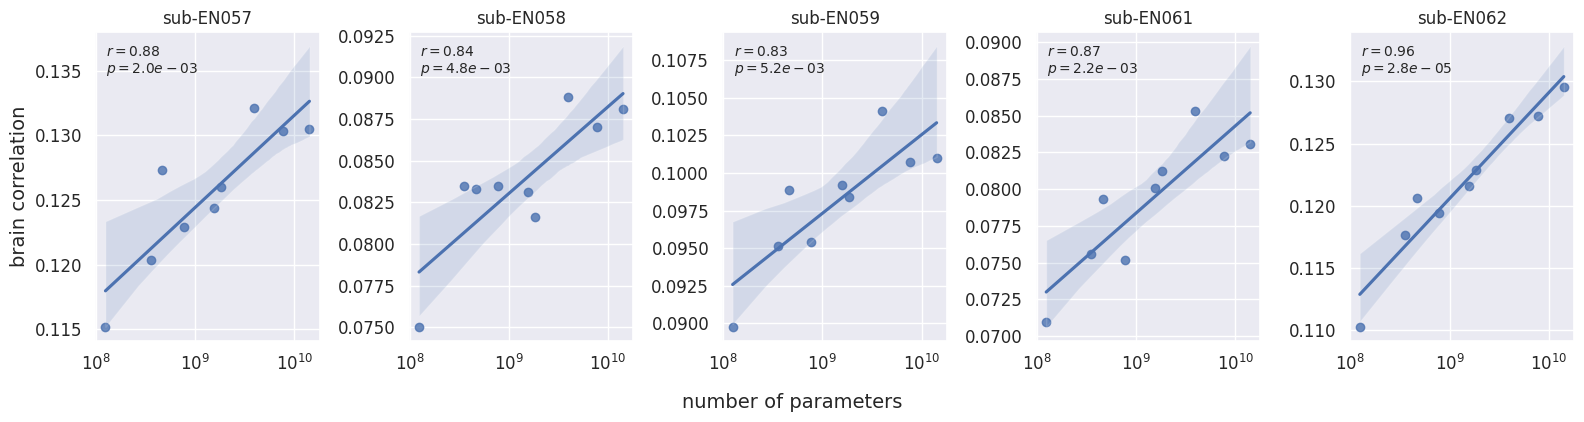

In [12]:
fh, axes = plt.subplots(1, n_subjects, figsize=(16, 4), sharex=True, sharey=False)
for ax, corr_models, sub_id in zip(axes, corr_models_subs, subject_list):
    sns.regplot(x=n_parameters,
                y=corr_models,
                logx=True, ax=ax);
    ax.set_xscale('log')
    r, p = pearsonr(np.log(n_parameters), 
                    corr_models)
    ax.text(0.05, 0.96,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
            ha='left', va='top', fontsize=10, transform=ax.transAxes)    
    ax.set_title('sub-{}'.format(sub_id))
axes[0].set_ylabel('brain correlation')
fh.text(0.5, -0.04, 'number of parameters', ha='center', fontsize=14)
plt.tight_layout()
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'braincorr_params_individuals.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

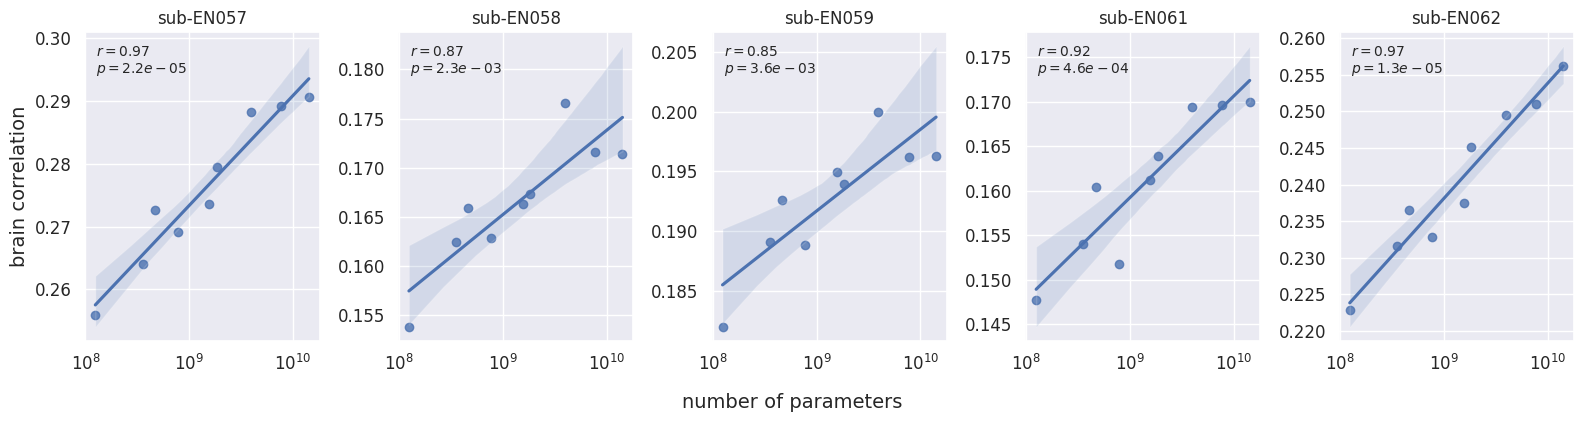

In [13]:
fh, axes = plt.subplots(1, n_subjects, figsize=(16, 4), sharex=True, sharey=False)
for ax, corr_models_90, sub_id in zip(axes, corr_models_90_subs, subject_list):
    sns.regplot(x=n_parameters,
                y=corr_models_90,
                logx=True, ax=ax);
    ax.set_xscale('log')
    r, p = pearsonr(np.log(n_parameters), 
                    corr_models_90)
    ax.text(0.05, 0.96,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
            ha='left', va='top', fontsize=10, transform=ax.transAxes)
    ax.set_title('sub-{}'.format(sub_id))
axes[0].set_ylabel('brain correlation')
fh.text(0.5, -0.04, 'number of parameters', ha='center', fontsize=14)
plt.tight_layout()
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'braincorr_params_individuals_90.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

In [14]:
################################ L/R Asymmetries ################################

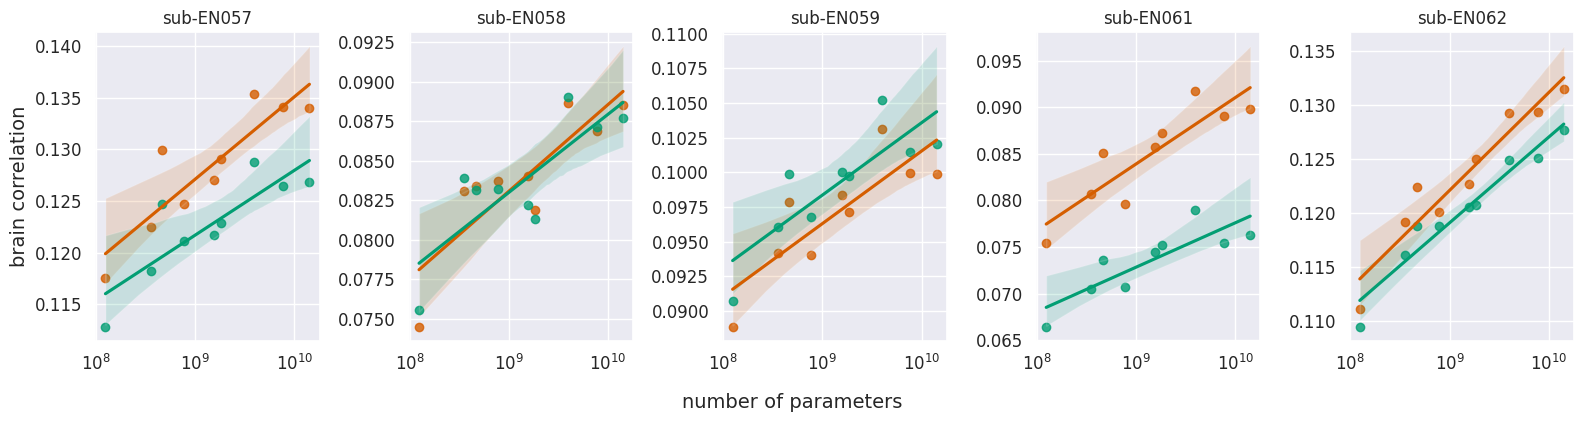

In [15]:
fh, axes = plt.subplots(1, n_subjects, figsize=(16, 4), sharex=True, sharey=False)
for ax, corr_l_models, corr_r_models, sub_id in zip(axes, corr_l_models_subs, corr_r_models_subs, subject_list):
    sns.regplot(x=n_parameters,
                y=np.mean(corr_l_models, axis=1),
                logx=True, ax=ax, color=l_r_colors[0]);
    sns.regplot(x=n_parameters,
                y=np.mean(corr_r_models, axis=1),
                logx=True, ax=ax, color=l_r_colors[1]);
    ax.set_xscale('log')
    ax.set_title('sub-{}'.format(sub_id))
axes[0].set_ylabel('brain correlation')
fh.text(0.5, -0.04, 'number of parameters', ha='center', fontsize=14)
plt.tight_layout()
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'braincorr_l_r_params_individuals.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

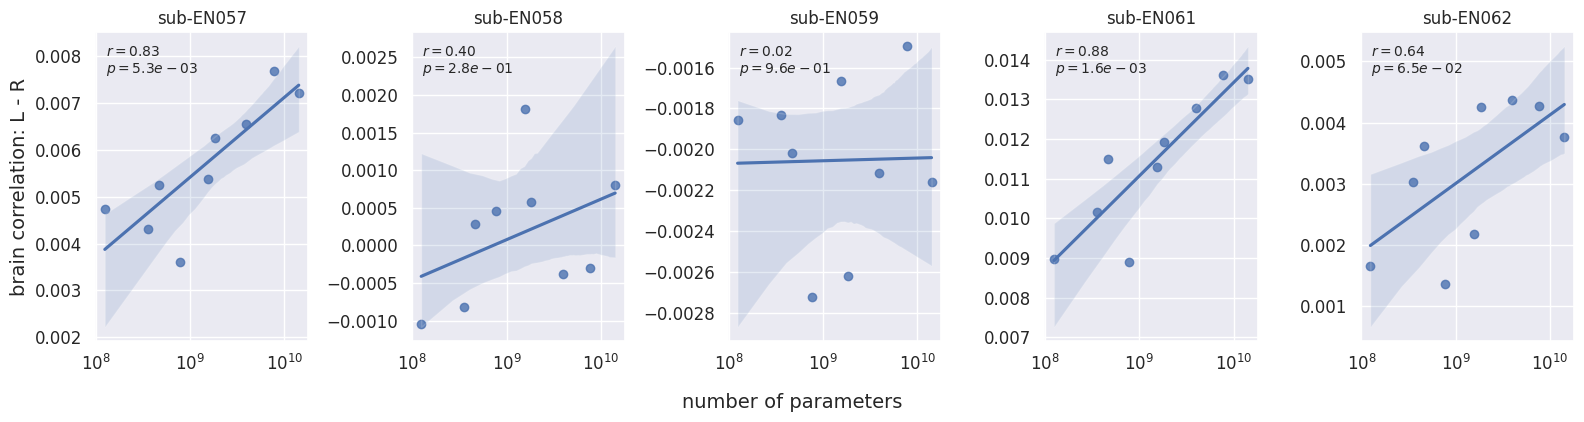

In [16]:
fh, axes = plt.subplots(1, n_subjects, figsize=(16, 4), sharex=True, sharey=False)
for ax, corr_l_models, corr_r_models, sub_id in zip(axes, corr_l_models_subs, corr_r_models_subs, subject_list):
    sns.regplot(x=n_parameters,
                y=np.mean(corr_l_models, axis=1)-np.mean(corr_r_models, axis=1),
                logx=True, ax=ax);
    ax.set_xscale('log')
    r, p = pearsonr(np.log(n_parameters), 
                    np.mean(corr_l_models, axis=1)-np.mean(corr_r_models, axis=1))
    ax.text(0.05, 0.96,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
            ha='left', va='top', fontsize=10, transform=ax.transAxes)
    ax.set_title('sub-{}'.format(sub_id))
axes[0].set_ylabel('brain correlation: L - R')
fh.text(0.5, -0.04, 'number of parameters', ha='center', fontsize=14)
plt.tight_layout()
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'braincorr_l_minus_r_params_individuals.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

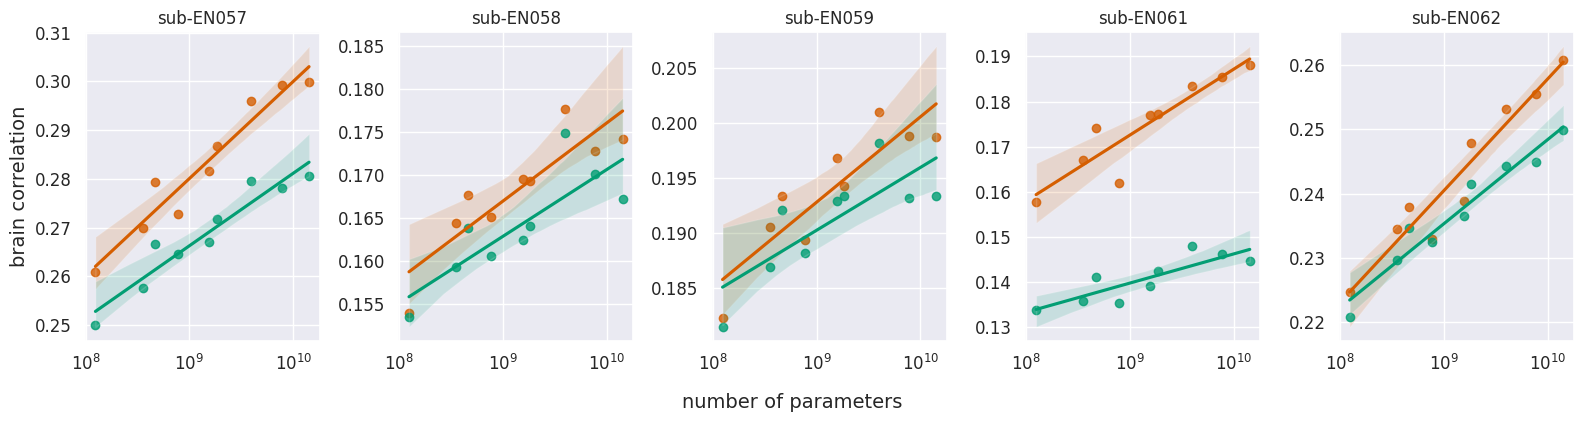

In [17]:
fh, axes = plt.subplots(1, n_subjects, figsize=(16, 4), sharex=True, sharey=False)
for ax, corr_l_models, corr_r_models, sub_id in zip(axes, corr_l_models_subs, corr_r_models_subs, subject_list):
    sns.regplot(x=n_parameters,
                y=np.percentile(corr_l_models, 90, axis=1),
                logx=True, ax=ax, color=l_r_colors[0]);
    sns.regplot(x=n_parameters,
                y=np.percentile(corr_r_models, 90, axis=1),
                logx=True, ax=ax, color=l_r_colors[1]);
    ax.set_xscale('log')
    ax.set_title('sub-{}'.format(sub_id))
axes[0].set_ylabel('brain correlation')
fh.text(0.5, -0.04, 'number of parameters', ha='center', fontsize=14)
plt.tight_layout()
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'braincorr_l_r_params_90_individuals.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

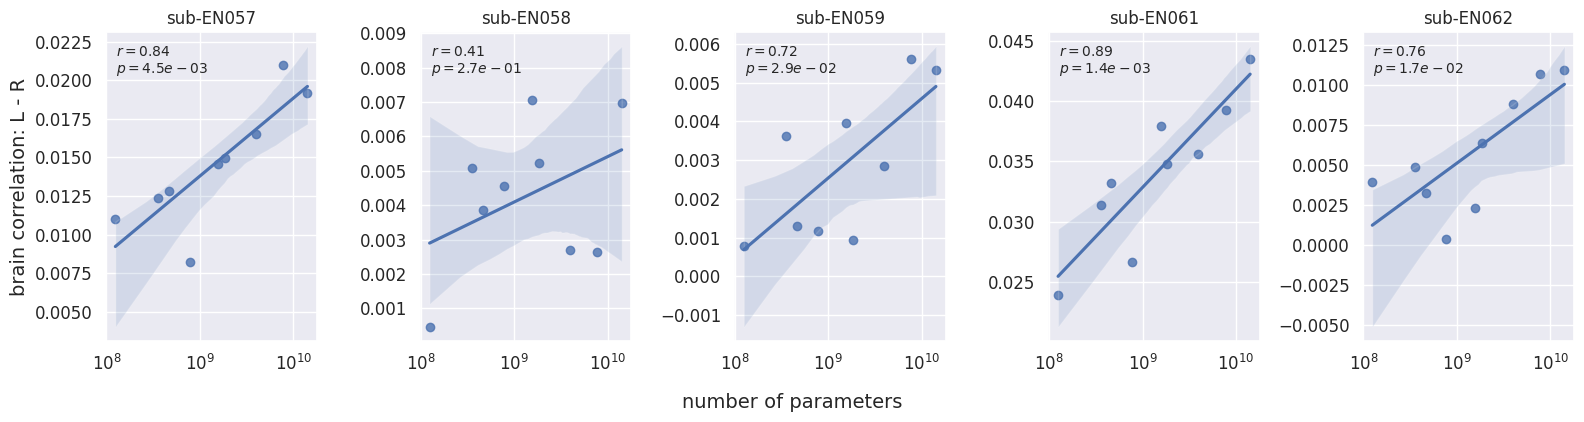

In [18]:
fh, axes = plt.subplots(1, n_subjects, figsize=(16, 4), sharex=True, sharey=False)
for ax, corr_l_models, corr_r_models, sub_id in zip(axes, corr_l_models_subs, corr_r_models_subs, subject_list):
    sns.regplot(x=n_parameters,
                y=np.percentile(corr_l_models, 90, axis=1)-np.percentile(corr_r_models, 90, axis=1),
                logx=True, ax=ax);
    ax.set_xscale('log')
    r, p = pearsonr(np.log(n_parameters), 
                    np.percentile(corr_l_models, 90, axis=1)-np.percentile(corr_r_models, 90, axis=1))
    ax.text(0.05, 0.96,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
            ha='left', va='top', fontsize=10, transform=ax.transAxes)
    ax.set_title('sub-{}'.format(sub_id))
axes[0].set_ylabel('brain correlation: L - R')
fh.text(0.5, -0.04, 'number of parameters', ha='center', fontsize=14)
plt.tight_layout()
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'braincorr_l_minus_r_params_90_individuals.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))